[*********************100%***********************]  1 of 1 completed

Class Weights: {0: np.float64(1.0769230769230769), 1: np.float64(0.9333333333333333)}
Epoch 1/50



C:\Users\PC\AppData\Local\Temp\ipykernel_17748\2949860225.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[indicator_cols] = data[indicator_cols].fillna(method='bfill')
C:\Users\PC\AppData\Local\Temp\ipykernel_17748\2949860225.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
C:\Users\PC\AppData\Local\Temp\ipykernel_17748\2949860225.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[['avg_sentiment', 'avg_score', 'article_count']] = data[['avg_sentiment', 'avg_score', 'article_count']].fillna(method='ffill')


1/1 - 3s - 3s/step - accuracy: 0.4800 - loss: 1.2770 - val_accuracy: 0.5000 - val_loss: 0.7506 - learning_rate: 1.0000e-03
Epoch 2/50
1/1 - 0s - 64ms/step - accuracy: 0.4600 - loss: 1.1340 - val_accuracy: 0.5000 - val_loss: 0.7400 - learning_rate: 1.0000e-03
Epoch 3/50
1/1 - 0s - 63ms/step - accuracy: 0.5200 - loss: 0.8960 - val_accuracy: 0.5000 - val_loss: 0.7296 - learning_rate: 1.0000e-03
Epoch 4/50
1/1 - 0s - 62ms/step - accuracy: 0.5800 - loss: 0.8033 - val_accuracy: 0.5000 - val_loss: 0.7197 - learning_rate: 1.0000e-03
Epoch 5/50
1/1 - 0s - 62ms/step - accuracy: 0.5400 - loss: 0.7695 - val_accuracy: 0.5000 - val_loss: 0.7158 - learning_rate: 1.0000e-03
Epoch 6/50
1/1 - 0s - 66ms/step - accuracy: 0.6200 - loss: 0.7484 - val_accuracy: 0.5000 - val_loss: 0.7133 - learning_rate: 1.0000e-03
Epoch 7/50
1/1 - 0s - 66ms/step - accuracy: 0.6000 - loss: 0.6905 - val_accuracy: 0.5000 - val_loss: 0.7121 - learning_rate: 1.0000e-03
Epoch 8/50
1/1 - 0s - 66ms/step - accuracy: 0.6600 - loss: 0.

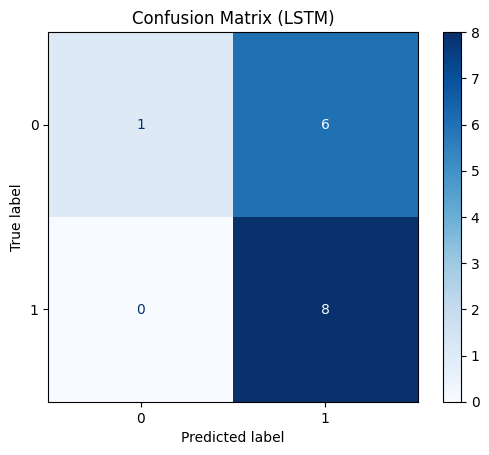

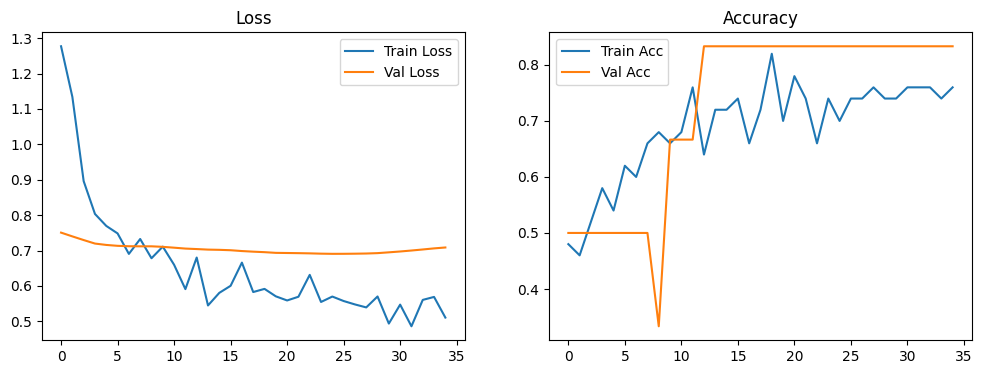

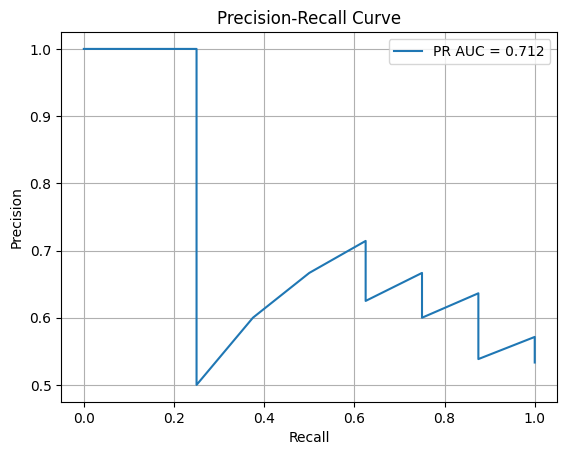

(<matplotlib.legend.Legend at 0x23c5676ebd0>, None, None)

In [ ]:
# %% Imports
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# %% Data Download
data = yf.download(tickers='^NDX', start = '2024-09-30',end = '2025-06-02')
data.columns = [f"{col[0]}" for col in data.columns]

# %% Add Indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

indicator_cols = ['RSI', 'EMAF', 'EMAM', 'EMAS']
data[indicator_cols] = data[indicator_cols].fillna(method='bfill')

# %% Target Columns
data['Adj Close'] = data[('Close')]
data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace=True)

# %% Merge with Sentiment Data
sentiment_df = pd.read_csv("../data/cleaned_scores.csv", parse_dates=["date"])
sentiment_df.rename(columns={'date': 'Date'}, inplace=True)
data = pd.merge(data, sentiment_df, how='left', on='Date')
data[['avg_sentiment', 'avg_score', 'article_count']] = data[['avg_sentiment', 'avg_score', 'article_count']].fillna(method='ffill')
data = data[data['Date'] > pd.to_datetime('2024-12-31')].reset_index(drop=True)

# %% Feature Prep
data.drop(['Close'], axis=1, inplace=True)
feature_columns = ['High', 'Low', 'Open', 'Volume', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'avg_sentiment', 'avg_score', 'article_count']

backcandles = 30

X = []
for j in range(len(feature_columns)):
    X.append([])
    for i in range(backcandles, len(data)):
        X[j].append(data[feature_columns].iloc[i - backcandles:i, j].values)

X = np.moveaxis(X, [0], [2])
y = data['TargetClass'].values[backcandles:]

# %% Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# %% Scaling
scaler = StandardScaler()
X_train_2d = X_train.reshape(-1, X_train.shape[2])
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)

X_test_2d = X_test.reshape(-1, X_test.shape[2])
X_test_scaled_2d = scaler.transform(X_test_2d)
X_test_scaled = X_test_scaled_2d.reshape(X_test.shape)

# %% Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# %% LSTM Model
inputs = Input(shape=(backcandles, len(feature_columns)))
x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(32))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# %% Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# %% Model Training
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    shuffle=True,
    verbose=2
)

# %% Threshold Optimization
y_pred_prob = model.predict(X_test_scaled).flatten()
thresholds = np.linspace(0, 1, 101)
f1_scores = [(th, f1_score(y_test, (y_pred_prob >= th).astype(int))) for th in thresholds]
best_thresh, best_f1 = max(f1_scores, key=lambda x: x[1])
print(f"Best Threshold by F1 score: {best_thresh:.2f} with F1: {best_f1:.3f}")

# %% Final Evaluation
y_pred = (y_pred_prob >= best_thresh).astype(int)
print("\n--- LSTM Classification Report ---")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

# %% Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (LSTM)")
plt.show()

# %% Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(), plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(), plt.title("Accuracy")
plt.show()

# %% PR AUC Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall'), plt.ylabel('Precision'), plt.title('Precision-Recall Curve')
plt.legend(), plt.grid(), plt.show()


In [30]:
data.to_csv("../data/ndx_lstm_predictions.csv", index=False)

In [28]:
print("Class balance:", np.bincount(y_train))


Class balance: [26 30]


In [29]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Number of positive samples:", np.sum(y))
print("Number of negative samples:", len(y) - np.sum(y))


X shape: (71, 30, 11)
y shape: (71,)
Number of positive samples: 38
Number of negative samples: 33
